In [ ]:
from google.colab import files
import pandas as pd

# Step 1: Upload the CSV file
uploaded = files.upload()

# Step 2: Get the filename
filename = list(uploaded.keys())[0]

# Step 3: Load the CSV into a DataFrame
df = pd.read_csv(filename)


Saving final.csv to final (1).csv


In [ ]:
# X = all input features
# y = target (Estimated_Final_Score)
X = df.drop(columns=["Estimated_Final_Score"])
y = df["Estimated_Final_Score"]


In [ ]:
from sklearn.model_selection import train_test_split

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
!pip install keras-tuner -q

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

# Wrap MLP inside a pipeline with preprocessing
from sklearn.pipeline import Pipeline

mlp_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("mlp", MLPRegressor(random_state=42, max_iter=500))
])

# Hyperparameter grid for pipeline
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100,50)],
    'mlp__activation': ['relu' ],
    'mlp__solver': ['adam'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1]
}

# Grid search
grid_search = GridSearchCV(mlp_pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'adam'}


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
## Get the best pipeline from GridSearchCV
best_mlp_pipeline = grid_search.best_estimator_

# Train the final model on the full training data
best_mlp_pipeline.fit(X_train, y_train)

print("Final MLP model trained with best hyperparameters.")


Final MLP model trained with best hyperparameters.


In [ ]:
best_mlp_pipeline = grid_search.best_estimator_


In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [ ]:
y_pred = best_mlp_pipeline.predict(X_test)


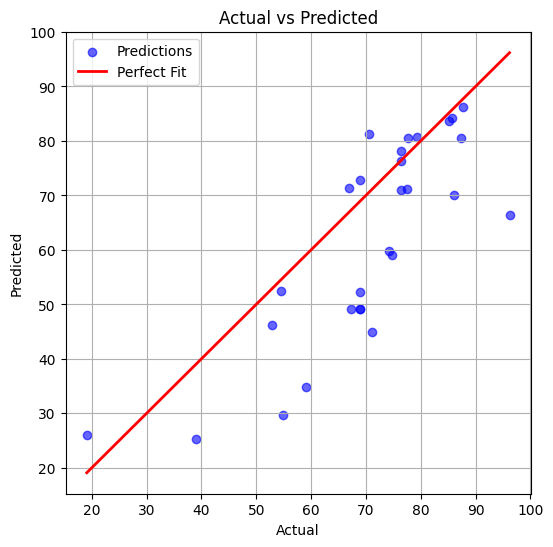

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predictions')  # dots
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Fit')  # red line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


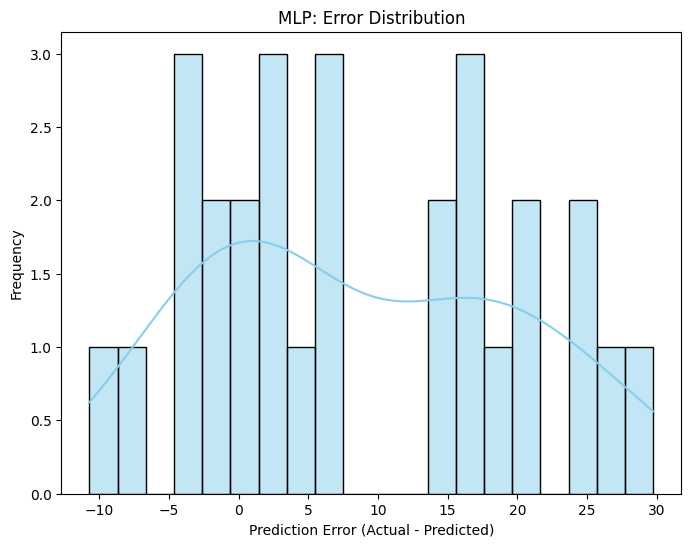

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate errors
errors = y_test - y_pred  # MLP errors

# Plot error distribution using Seaborn
plt.figure(figsize=(8,6))
sns.histplot(errors, bins=20, kde=True, color='skyblue', edgecolor='black')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("MLP: Error Distribution")
plt.show()


In [ ]:
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error (MSE): 195.05
Mean Absolute Error (MAE): 10.83
R² Score: 0.20


In [ ]:
import pandas as pd

results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': errors
})

# Show first 20 rows
print(results.head(20))


        Actual  Predicted      Error
105  77.550000  71.146325   6.403675
104  68.983197  52.329477  16.653720
12   76.350000  76.289971   0.060029
26   59.150000  34.788953  24.361047
123  85.750000  84.153731   1.596269
66   74.850000  59.059862  15.790138
64   52.950000  46.192429   6.757571
115  74.150000  59.776478  14.373522
133  87.300000  80.561949   6.738051
85   76.350000  71.071580   5.278420
84   79.350000  80.784773  -1.434773
45   71.050000  44.930226  26.119774
69   67.250000  49.170396  18.079604
67   86.050000  70.095711  15.954289
31   68.983197  49.153354  19.829843
42   77.750000  80.559570  -2.809570
27   85.150000  83.668803   1.481197
19   76.350000  78.073031  -1.723031
132  39.000000  25.251357  13.748643
56   70.550000  81.267696 -10.717696


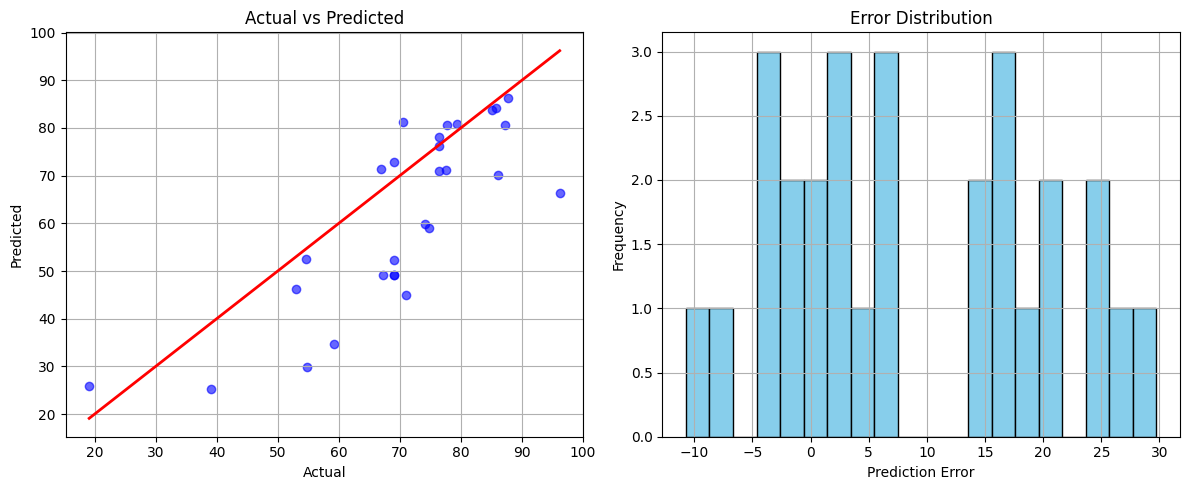

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Scatter plot
axes[0].scatter(y_test, y_pred, color='blue', alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")
axes[0].set_title("Actual vs Predicted")
axes[0].grid(True)

# Error histogram
axes[1].hist(errors, bins=20, color='skyblue', edgecolor='black')
axes[1].set_xlabel("Prediction Error")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Error Distribution")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number"]).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])


In [ ]:
from sklearn.model_selection import GridSearchCV

# Random Forest pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(random_state=42))
])

# Hyperparameter grid
param_grid = {
    "rf__n_estimators": [100, 200, 300],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 5, 10]
}

# Grid search
grid_search_rf = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best Random Forest Hyperparameters:", grid_search_rf.best_params_)


Best Random Forest Hyperparameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


In [ ]:
# Get the best pipeline from GridSearchCV
best_rf_pipeline = grid_search_rf.best_estimator_

# Train the final model on the full training data
best_rf_pipeline.fit(X_train, y_train)

print("Random Forest model trained with best hyperparameters.")


Random Forest model trained with best hyperparameters.


In [ ]:
# Print best hyperparameters
print("Best Random Forest Hyperparameters:", grid_search_rf.best_params_)


Best Random Forest Hyperparameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions
y_pred_rf = best_rf_pipeline.predict(X_test)

# Evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"MSE: {mse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R²: {r2_rf:.2f}")


MSE: 24.83
MAE: 3.51
R²: 0.90


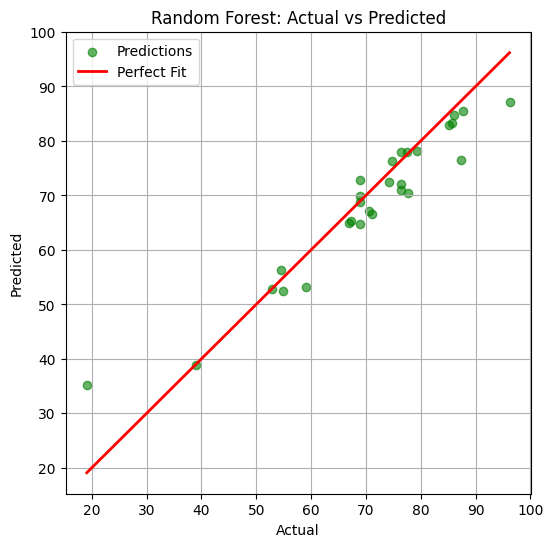

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Fit')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


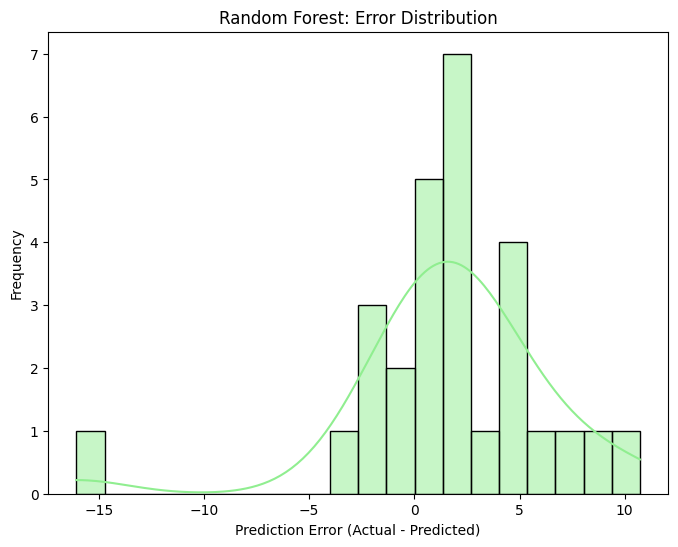

In [ ]:
import seaborn as sns

errors_rf = y_test - y_pred_rf

plt.figure(figsize=(8,6))
sns.histplot(errors_rf, bins=20, kde=True, color='lightgreen', edgecolor='black')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Random Forest: Error Distribution")
plt.show()


In [ ]:
import pandas as pd

results_rf = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_rf,
    "Error": errors_rf
})

print(results_rf.head(20))


        Actual  Predicted      Error
105  77.550000  77.983744  -0.433744
104  68.983197  72.789123  -3.805926
12   76.350000  71.005928   5.344072
26   59.150000  53.225750   5.924250
123  85.750000  83.286750   2.463250
66   74.850000  76.349494  -1.499494
64   52.950000  52.752500   0.197500
115  74.150000  72.501326   1.648674
133  87.300000  76.573811  10.726189
85   76.350000  77.964410  -1.614410
84   79.350000  78.146162   1.203838
45   71.050000  66.530152   4.519848
69   67.250000  65.288416   1.961584
67   86.050000  84.813500   1.236500
31   68.983197  64.844723   4.138473
42   77.750000  70.494672   7.255328
27   85.150000  82.872500   2.277500
19   76.350000  72.048789   4.301211
132  39.000000  38.924750   0.075250
56   70.550000  67.221248   3.328752


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_mlp = best_mlp_pipeline.predict(X_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)


In [ ]:
y_pred_rf = best_rf_pipeline.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)


In [ ]:
print("MLP:   MSE =", mse_mlp, ", MAE =", mae_mlp, ", R² =", r2_mlp)
print("RF:    MSE =", mse_rf, ", MAE =", mae_rf, ", R² =", r2_rf)


MLP:   MSE = 195.05135040116994 , MAE = 10.83118085649426 , R² = 0.20212212284051645
RF:    MSE = 24.830226602000057 , MAE = 3.5144060304449445 , R² = 0.8984293702666213


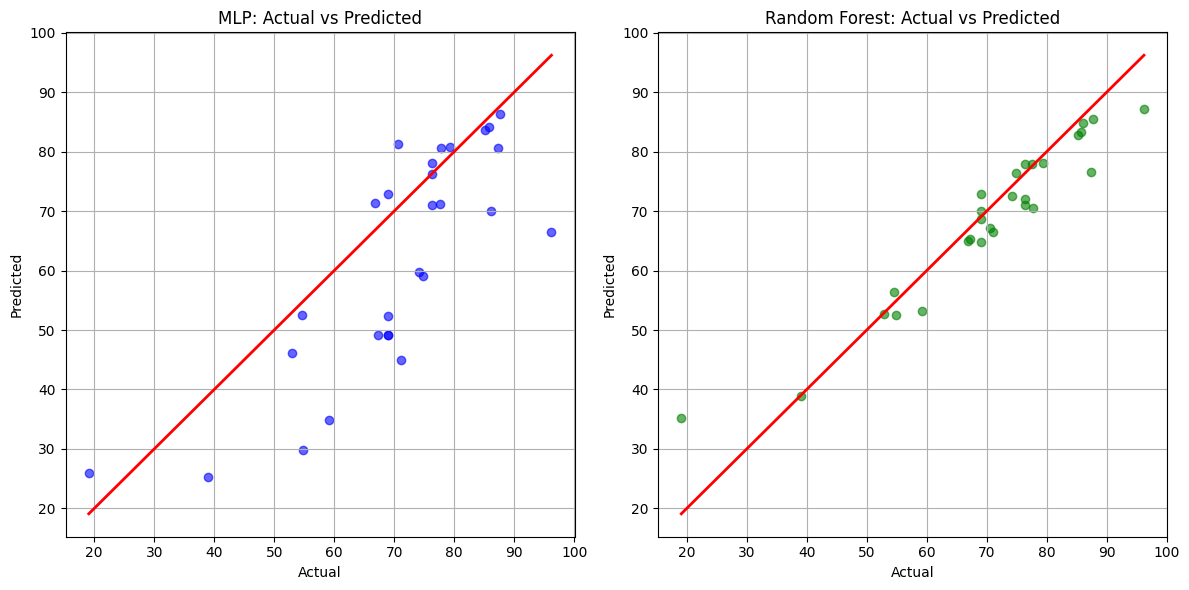

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# MLP scatter
axes[0].scatter(y_test, y_pred_mlp, color='blue', alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
axes[0].set_title("MLP: Actual vs Predicted")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")
axes[0].grid(True)

# Random Forest scatter
axes[1].scatter(y_test, y_pred_rf, color='green', alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
axes[1].set_title("Random Forest: Actual vs Predicted")
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")
axes[1].grid(True)

plt.tight_layout()
plt.show()


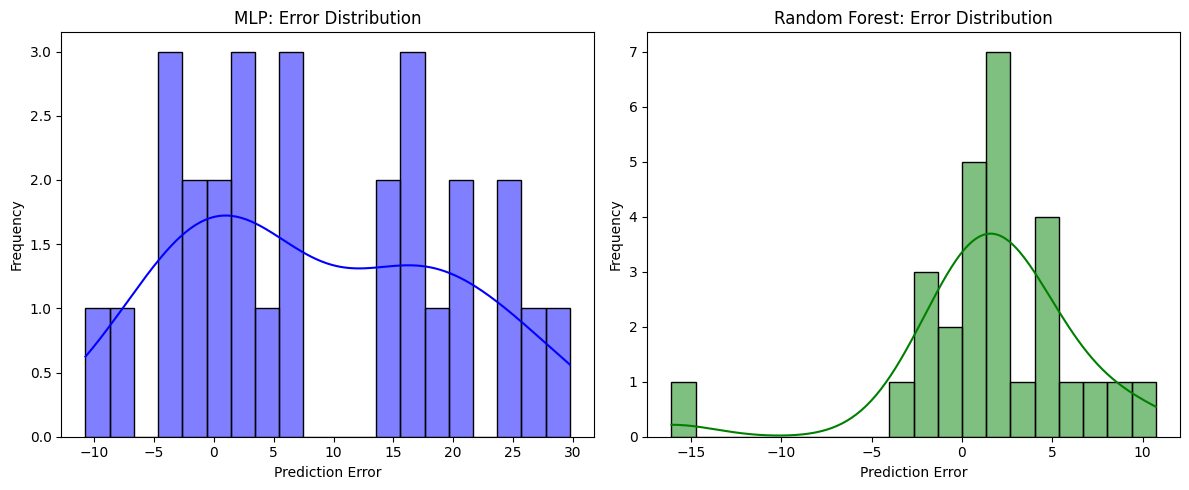

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# MLP errors
sns.histplot(y_test - y_pred_mlp, bins=20, kde=True, color='blue', ax=axes[0])
axes[0].set_title("MLP: Error Distribution")
axes[0].set_xlabel("Prediction Error")
axes[0].set_ylabel("Frequency")

# Random Forest errors
sns.histplot(y_test - y_pred_rf, bins=20, kde=True, color='green', ax=axes[1])
axes[1].set_title("Random Forest: Error Distribution")
axes[1].set_xlabel("Prediction Error")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


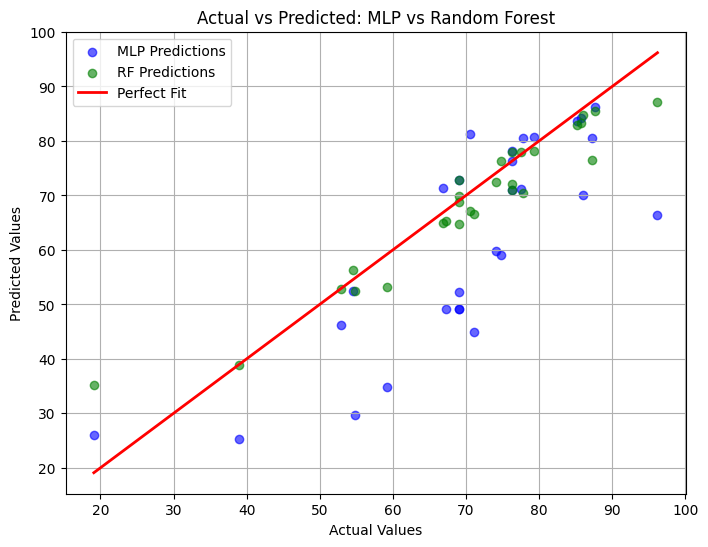

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.scatter(y_test, y_pred_mlp, color='blue', alpha=0.6, label='MLP Predictions')
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.6, label='RF Predictions')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linewidth=2, label='Perfect Fit')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted: MLP vs Random Forest")
plt.legend()
plt.grid(True)
plt.show()


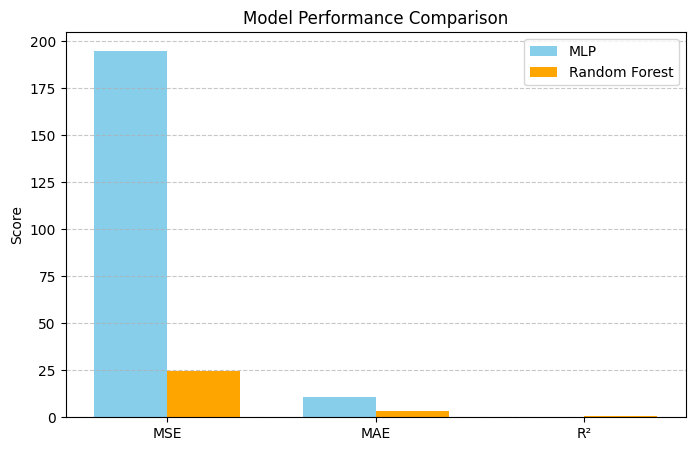

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ["MSE", "MAE", "R²"]
mlp_scores = [mse_mlp, mae_mlp, r2_mlp]
rf_scores = [mse_rf, mae_rf, r2_rf]

x = np.arange(len(metrics))  # positions for metrics
width = 0.35  # bar width

# Plot
plt.figure(figsize=(8,5))
plt.bar(x - width/2, mlp_scores, width, label="MLP", color="skyblue")
plt.bar(x + width/2, rf_scores, width, label="Random Forest", color="orange")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
